# ECF - MACHINE LEARNING SUPERVISÉ - *Scikit-learn*
**Sujet**  : Prédiction de Churn Client - TeleCom+ 

**Dataset:** `03_DONNEES.csv` (7 043 clients)  
**Target:** `Churn` (Yes/No)

**Livrables** :
Minimum (obligatoire) :
1. **Notebook Jupyter** : Sections 1-4 (Scikit-learn)
   - Code exécutable, commenté, avec visualisations
2. **Rapport** (2-3 pages) : Résumé, méthodo, résultats, recommandations
3. **Fichiers de résultats** : predictions_test.csv, model_metrics.json, feature_importance.csv

---
---

## Introduction
Dans ce notebook nous allons analyser les données de TeleCom+ afin de construire un modèle prédictif avec `Scikit-learn` pour identifier les clients à risque de départ (`Churn`). Nous allons suivre les étapes suivantes :
- [Import des librairies](#Import-des-librairies)<a id="Import-des-librairies-toc"></a>
- [Configurations](#Configurations)<a id="Configurations-toc"></a>
- [Chemins des donnees](#Chemins-des-donnees)<a id="Chemins-des-donnees-toc"></a>
- [1. EXPLORATION ET PREPARATION](#1.-EXPLORATION-ET-PREPARATION)<a id="1.-EXPLORATION-ET-PREPARATION-toc"></a>
  - [1.1 Charger les donnees et afficher info/describe](#1.1-donnees)<a id="1.1-donnees-toc"></a>
  - [1.2 Analyser la distribution de Churn](#1.2-dist-Churn)<a id="1.2-dist-Churn-toc"></a>
  - [1.3 Transformer les valeurs de la colonne target 'Churn' en numerique : 1 ou 0 a la place de Yes ou No](#1.3-transformer)<a id="1.3-transformer-toc"></a>
  - [1.4 Verifier les lignes dupliquees](#1.4-verif-dup)<a id="1.4-verif-dup-toc"></a>
  - [1.5 Identifier et traiter les valeurs manquantes](#1.5-Identifier)<a id="1.5-Identifier-toc"></a>
  - [1.6 Encoder les variables categorielles (One-hot encoding)](#1.6-Encoder)<a id="1.6-Encoder-toc"></a>
  - [1.7 Normaliser les variables numeriques (StandardScaler)](#1.7-Normaliser)<a id="1.7-Normaliser-toc"></a>
  - [1.8 Preprocesseur : appliquer les pipelines](#1.8-Preprocesseur)<a id="1.8-Preprocesseur-toc"></a>
- [2. MODELISATION](#2.-MODELISATION)<a id="2.-MODELISATION-toc"></a>
  - [2.1 Split train/test (70/30, stratify=y, seed=42)](#split-train-test)<a id="split-train-test-toc"></a>
  - [2.2 Entrainer 3 modeles : Logistic Regression, Random Forest, Gradient Boosting](#2.2-Entrainer-3-modeles)<a id="2.2-Entrainer-3-modeles-toc"></a>
  - [2.3 Calculer accuracy, precision, recall, f1-score pour chaque](#calcule-metrics)<a id="calcule-metrics-toc"></a>
  - [2.4 Selectionner le meilleur modele](#2.4-Selectionner-le-meilleur-modele)<a id="2.4-Selectionner-le-meilleur-modele-toc"></a>
- [3. EVALUATION ET INTERPRETATION](#3.-EVALUATION-ET-INTERPRETATION)<a id="3.-EVALUATION-ET-INTERPRETATION-toc"></a>
  - [3.1 Afficher matrice de confusion du meilleur modele](#3.1-mc)<a id="3.1-mc-toc"></a>
  - [3.2 Extraire et visualiser les 10 features les plus importantes](#3.2-feat-imp)<a id="3.2-feat-imp-toc"></a>
  - [3.3 Cross-validation (5-fold)](#3.3-Cross-validation) <a id="3.3-Cross-validation-toc"></a>
  - [3.4 GridSearchCV pour optimisation hyperparametres](#3.4-GridSearchCV) <a id="3.4-GridSearchCV-toc"></a>
- [4. RECOMMANDATIONS METIER](#4.-RECOMMANDATIONS-METIER) <a id="4.-RECOMMANDATIONS-METIER-toc"></a>
  - [4.1 Identifier les 20 clients avec probabilité churn > 80%](#41-prob-churn) <a id="41-prob-churn-toc"></a>
  - [4.2 Analyser leurs profils (Contract, InternetService, tenure, MonthlyCharges)](#42-analyse-profils) <a id="42-analyse-profils-toc"></a>
  - [4.3 Proposer 3 actions de retention](#4.3-actions) <a id="4.3-actions-toc"></a>
  - [4.4 Estimer ROI (cout action vs economie)](#4.4-ROI) <a id="4.4-ROI-toc"></a>

---

## Import des librairies
<div style="text-align: right;">
<a href="#Import-des-librairies-toc">⬆ Retour en haut</a>
</div>


In [1]:
import os
from pathlib import Path
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, confusion_matrix, f1_score, recall_score, make_scorer, classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
import warnings

---

## Configurations
<div style="text-align: right;">
<a href="#Configurations-toc">⬆ Retour en haut</a>
</div>

In [2]:
# --- Supprimer les warnings Pandas
warnings.filterwarnings("ignore")

---

## Chemins des donnees
<div style="text-align: right;">
<a href="#Chemins-des-donnees-toc">⬆ Retour en haut</a>
</div>

In [3]:
# ==============================================================================================================
#                                                  INPUTS
# ==============================================================================================================
IN_DIR = (Path.cwd() / ".." / "data").resolve()
IN_CSV = os.path.join(IN_DIR, "03_DONNEES.csv")

# ==============================================================================================================
#                                                OUTPUTS
# ==============================================================================================================
OUT_DIR = (Path.cwd() / ".." / "output").resolve()
OUT_SKLEARN_DIR = os.path.join(OUT_DIR, "sklearn")
# Assurer OUT_SKLEARN_DIR
Path(OUT_SKLEARN_DIR).mkdir(parents=True, exist_ok=True)

# Fichiers de résultats obligatoires
OUT_PRED_TEST_CSV = os.path.join(OUT_SKLEARN_DIR, "predictions_test.csv")
OUT_METRICS_JSON = os.path.join(OUT_SKLEARN_DIR, "model_metrics.json")
OUT_FEAT_IMP_CSV = os.path.join(OUT_SKLEARN_DIR, "features_importance.csv") 

# Fichiers de résultats optionels
OUT_MATR_CONF_PNG = os.path.join(OUT_SKLEARN_DIR, "matrice_confusion.png") 
OUT_VIS_FEAT_IMP_PNG = os.path.join(OUT_SKLEARN_DIR, "features_importance.png") 
OUT_HIGH_RISK_CSV = os.path.join(OUT_SKLEARN_DIR, "top_risk_churn_client.csv")

---

## 1. EXPLORATION ET PREPARATION
<div style="text-align: right;">
<a href="#1.-EXPLORATION-ET-PREPARATION-toc">⬆ Retour en haut</a>
</div>

<a id="1.1-donnees"></a>
### 1.1 Charger les donnees et afficher info/describe
<div style="text-align: right;">
<a href="#1.1-donnees-toc">⬆ Retour en haut</a>
</div>

In [4]:
# --- Charger les données
df = pd.read_csv(IN_CSV)

# --- Apperçu des données
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,InternetCharges,MonthlyCharges,TotalCharges,Churn
0,customer_1,Male,0,No,Yes,51,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,0.00,43.53,2220.03,No
1,customer_2,Male,1,Yes,Yes,14,Yes,Yes,DSL,No internet service,No internet service,Yes,No internet service,Yes,No internet service,Two year,46.00,109.39,1531.46,No
2,customer_3,Female,0,Yes,No,71,No,No,DSL,Yes,No,Yes,Yes,No,Yes,One year,34.36,99.36,7054.56,No
3,customer_4,Male,1,Yes,No,60,Yes,No phone service,Fiber optic,No internet service,No internet service,No,No internet service,Yes,No internet service,Two year,65.56,115.12,6907.20,No
4,customer_5,Male,0,Yes,No,20,No,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,0.00,20.00,400.00,Yes


In [5]:
# --- Afficher info/describe
print("-Les types de données :")
df.info()
print("\n-Description des données (tendances générales) :")
df.describe()

-Les types de données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  InternetCharges   

,SeniorCitizen,tenure,InternetCharges,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.503337,35.902598,46.783412,91.006110,3279.987099
std,0.500024,20.945973,43.812203,54.001753,2976.418208
min,0.000000,0.000000,0.000000,20.000000,0.000000
25%,0.000000,18.000000,0.000000,39.310000,940.000000
50%,1.000000,36.000000,40.670000,91.350000,2284.460000
75%,1.000000,54.000000,80.625000,132.930000,5022.900000
max,1.000000,72.000000,139.930000,238.040000,15151.680000


<a id="1.2-dist-Churn"></a>
### 1.2 Analyser la distribution de Churn
<div style="text-align: right;">
<a href="#1.2-dist-Churn-toc">⬆ Retour en haut</a>
</div>

-Visualisation graphique de la distribution de 'Churn'


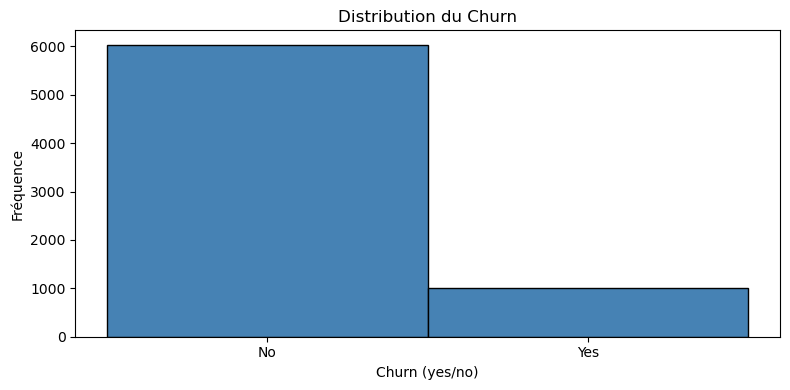


-Visualisation numérique de la distribution de 'Churn'
Churn
No     6030
Yes    1013
Name: count, dtype: int64

%:
Churn
No     85.616925
Yes    14.383075
Name: proportion, dtype: float64


In [6]:
# --- Visualisation graphique de la distribution de 'Churn'
print("-Visualisation graphique de la distribution de 'Churn'")
plt.figure(figsize=(8, 4))
plt.hist(df["Churn"], bins=[-0.5, 0.5, 1.5], edgecolor="k", color="steelblue")
plt.xlabel("Churn (yes/no)")
plt.ylabel("Fréquence")
plt.title("Distribution du Churn")

# Forcer l'affichage uniquement de 0 et 1
plt.tight_layout()
plt.show()

# --- Visualisation numérique de la distribution de 'Churn'
print("\n-Visualisation numérique de la distribution de 'Churn'")
count_dist_classes = df['Churn'].value_counts()
percent_dist_classes = df["Churn"].value_counts(normalize=True) * 100
print(count_dist_classes)

print("\n%:")
print(percent_dist_classes)

**Analyse** :
'Churn' est fortement déséquilibrée :

- La majorité des clients ne churn pas
- Les churners sont une minorité (classe rare)

<a id="1.3-transformer"></a>
### 1.3 Transformation des valeurs de la colonne target Churn en numerique : 1 ou 0 a la place de Yes ou No
<div style="text-align: right;">
<a href="#1.3-transformer-toc">⬆ Retour en haut</a>
</div>

In [7]:
df_tr = df.copy()
df_tr["Churn"] = df_tr["Churn"].map({"Yes": 1, "No": 0})

df_tr.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,InternetCharges,MonthlyCharges,TotalCharges,Churn
0,customer_1,Male,0,No,Yes,51,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,0.00,43.53,2220.03,0
1,customer_2,Male,1,Yes,Yes,14,Yes,Yes,DSL,No internet service,No internet service,Yes,No internet service,Yes,No internet service,Two year,46.00,109.39,1531.46,0
2,customer_3,Female,0,Yes,No,71,No,No,DSL,Yes,No,Yes,Yes,No,Yes,One year,34.36,99.36,7054.56,0
3,customer_4,Male,1,Yes,No,60,Yes,No phone service,Fiber optic,No internet service,No internet service,No,No internet service,Yes,No internet service,Two year,65.56,115.12,6907.20,0
4,customer_5,Male,0,Yes,No,20,No,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,0.00,20.00,400.00,1


<a id="1.4-verif-dup"></a>
### 1.4 Verification des lignes dupliquees
<div style="text-align: right;">
<a href="#1.4-verif-dup-toc">⬆ Retour en haut</a>
</div>

In [8]:
nbr_dup = df_tr.duplicated(subset=["customerID"]).sum()
if (nbr_dup == 0):
    print("=> Pas de doublons")
else:
    print(f"/!\: Présence de doublons : {nbr_dup} ligne en trop")


=> Pas de doublons


<a id="1.5-Identifier"></a>
### 1.5 Identifier et traiter les valeurs manquantes
<div style="text-align: right;">
<a href="#1.5-Identifier-toc">⬆ Retour en haut</a>
</div>

In [9]:
# --- Identifier les valeurs manquantes
# Affichage du nombre des valeurs nulles pour chaque colonne -> Tableau
print("-Affichage du nombre des valeurs nulles pour chaque colonne :")
print(df_tr.isna().sum())

# Nombre total des valeurs nulles -> Int
missing_count = df_tr.isna().sum().sum()
print("\n-Nombre total des valeurs nulles :", missing_count)

# info
if missing_count == 0:
    print("\n=> Pas de valeurs manquantes")
else:
    print(f"\n=> /!\: Présence de valeurs manquantes : {missing_count}")

-Affichage du nombre des valeurs nulles pour chaque colonne :
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
InternetCharges     0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

-Nombre total des valeurs nulles : 0

=> Pas de valeurs manquantes


<a id="1.6-Encoder"></a>
### 1.6 Encoder les variables categorielles (One-hot encoding)
<div style="text-align: right;">
<a href="#1.6-Encoder-toc">⬆ Retour en haut</a>
</div>

In [10]:
# --- Features
X = df_tr.drop(["Churn", "customerID"], axis=1).copy()
# --- Target
y = df_tr["Churn"].copy()

In [11]:
# --- Définir les features catégorielles :
categorical_features = X.select_dtypes(include=["object"]).columns.to_list()
print(f"-Variables categorielle : {categorical_features}")
print(f"-Nombre de variables categorielle : {len(categorical_features)}")

# --- Pipeline pour encoder les variables catégorielles (One-hot encoding)
categorical_transformer = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])
print("=> Préparation du categorical transformer : Encoder les variables catégorielles (One-hot encoding)")

-Variables categorielle : ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract']
-Nombre de variables categorielle : 13
=> Préparation du categorical transformer : Encoder les variables catégorielles (One-hot encoding)


<a id="1.7-Normaliser"></a>
### 1.7 Normaliser les variables numeriques (StandardScaler)
<div style="text-align: right;">
<a href="#1.7-Normaliser-toc">⬆ Retour en haut</a>
</div>

In [12]:
# --- Définir les features numériques :
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.to_list()
print(f"-Variables numériques : {numeric_features}")
print(f"-Nombre de variables numériques : {len(numeric_features)}")

# --- Pipeline pour normaliser les variables numériques (StandardScaler)
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])
print("=> Préparation du numeric transformer : Normaliser les variables numériques (StandardScaler)")

-Variables numériques : ['SeniorCitizen', 'tenure', 'InternetCharges', 'MonthlyCharges', 'TotalCharges']
-Nombre de variables numériques : 5
=> Préparation du numeric transformer : Normaliser les variables numériques (StandardScaler)


<a id="1.8-Preprocesseur"></a>
### 1.8 Preprocesseur : application des pipelines
<div style="text-align: right;">
<a href="#1.8-Preprocesseur-toc">⬆ Retour en haut</a>
</div>

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

---

## 2. MODELISATION         
<div style="text-align: right;">
<a href="#2.-MODELISATION-toc">⬆ Retour en haut</a>
</div>


<a id="split-train-test"></a>
### 2.1 Split train/test (70/30, stratify=y, seed=42)
<div style="text-align: right;">
<a href="#split-train-test-toc">⬆ Retour en haut</a>
</div>

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, # 30% pour les tests, 70% pour l'entrainement
    random_state=42,
    stratify=y # Maintient les proportions de classes
)

### 2.2 Entrainer 3 modeles
  - Logistic Regression
  - Random Forest
  - Gradient Boosting
<div style="text-align: right;">
<a href="#2.2-Entrainer-3-modeles-toc">⬆ Retour en haut</a>
</div>

In [15]:
# --- Modèle Logistic Regression

# Definition du modèle
model_lr = LogisticRegression(random_state=42, max_iter=1000)

# Pipeline du modèle
pipeline_lr = Pipeline(steps=[("preprocessor", preprocessor), ("model", model_lr)])

# Entrainement & mesure du temps
t0 = time.perf_counter()
pipeline_lr.fit(X_train, y_train)
t_lr = time.perf_counter() - t0

In [16]:
# --- Modèle Random Forest

# Definition du modèle
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Pipeline du modèle
pipeline_rf = Pipeline(steps=[("preprocessor", preprocessor), ("model", model_rf)])

# Entrainement & mesure du temps
t0 = time.perf_counter()
pipeline_rf.fit(X_train, y_train)
t_rf = time.perf_counter() - t0

In [17]:
# --- Modèle Gradient Boosting

# Definition du modèle
model_gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Pipeline du modèle
pipeline_gb = Pipeline(steps=[("preprocessor", preprocessor), ("model", model_gb)])

# Entrainement & mesure du temps
t0 = time.perf_counter()
pipeline_gb.fit(X_train, y_train)
t_gb = time.perf_counter() - t0

<a id="calcule-metrics"></a>
### 2.3 Calculer accuracy, precision, recall, f1-score pour chaque
<div style="text-align: right;">
<a href="#calcule-metrics-toc">⬆ Retour en haut</a>
</div>

In [18]:
# --- Modèle Logistic Regression
y_pred_lr = pipeline_lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
print("-Rapport de classification pour Logistic Regression :")
print(classification_report(y_test, y_pred_lr))

# --- Modèle Random Forest
y_pred_rf = pipeline_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
print("-Rapport de classification pour Random Forest :")
print(classification_report(y_test, y_pred_rf))

# --- Modèle Gradient Boosting
y_pred_gb = pipeline_gb.predict(X_test)
acc_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
print("-Rapport de classification pour Gradient Boosting :")
print(classification_report(y_test, y_pred_gb))

-Rapport de classification pour Logistic Regression :
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1809
           1       0.67      0.01      0.03       304

    accuracy                           0.86      2113
   macro avg       0.76      0.51      0.47      2113
weighted avg       0.83      0.86      0.79      2113

-Rapport de classification pour Random Forest :
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1809
           1       0.34      0.05      0.09       304

    accuracy                           0.85      2113
   macro avg       0.60      0.52      0.50      2113
weighted avg       0.79      0.85      0.80      2113

-Rapport de classification pour Gradient Boosting :
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1809
           1       0.44      0.04      0.07       304

    accuracy                

In [19]:
# --- Export des metrics
sklearn_results = {
    "Logistic Regression": {
        "time":  format(t_lr, ".3f"),
        "accuracy":   format(acc_lr, ".3f"),
        "precision":  format(precision_lr, ".3f"),
        "recall":    format(recall_lr, ".3f"),
		"f1-score": format(f1_lr, ".3f")
    },
    "Random Forest": {
        "time":  format(t_rf, ".3f"),
        "accuracy":   format(acc_rf, ".3f"),
        "precision":  format(precision_rf, ".3f"),
        "recall":    format(recall_rf, ".3f"),
		"f1-score": format(f1_rf, ".3f")
    },
	"Gradient Boosting": {
		"time":  format(t_gb, ".3f"),
        "accuracy":   format(acc_gb, ".3f"),
        "precision":  format(precision_gb, ".3f"),
        "recall":    format(recall_gb, ".3f"),
		"f1-score": format(f1_gb, ".3f")
	}
}

print("-Metrics sklearn pour les 3 modèles de classification : ")
print(json.dumps(sklearn_results, indent=4, ensure_ascii=False))

with open(OUT_METRICS_JSON, "w", encoding="utf-8") as f:
    json.dump(sklearn_results, f, indent=2, ensure_ascii=False)

print(f"\n=> Enregistrement des metrics : {OUT_METRICS_JSON}")


-Metrics sklearn pour les 3 modèles de classification : 
{
    "Logistic Regression": {
        "time": "0.072",
        "accuracy": "0.857",
        "precision": "0.667",
        "recall": "0.013",
        "f1-score": "0.026"
    },
    "Random Forest": {
        "time": "0.481",
        "accuracy": "0.849",
        "precision": "0.340",
        "recall": "0.053",
        "f1-score": "0.091"
    },
    "Gradient Boosting": {
        "time": "0.779",
        "accuracy": "0.855",
        "precision": "0.440",
        "recall": "0.036",
        "f1-score": "0.067"
    }
}

=> Enregistrement des metrics : /home/jovyan/output/sklearn/model_metrics.json


### 2.4 Selectionner le meilleur modele
<div style="text-align: right;">
<a href="#2.4-Selectionner-le-meilleur-modele-toc">⬆ Retour en haut</a>
</div>

On se basant sur les metrics, le meilleur modèle pour notre cas est le **Random Forest**. Justification :
- Temps d'exécution faible
- Les accurracy sont prôches pour les 3 modèles et il n'est pas très utile pour détécter les clients à risque
- meilleur recall => détecte le plus de churners que les autres modèles
- meilleur f1-score => équilibre entre précision et Recall

NB: Même si que le **Random Forest** est le meilleur des 3 modèles, actuellement il détécte peu de clients à risque : Recall < 6% signifie qu'il rate 94% des churners !

---

## 3. EVALUATION ET INTERPRETATION
<div style="text-align: right;">
<a href="#3.-EVALUATION-ET-INTERPRETATION-toc">⬆ Retour en haut</a>
</div>

<a id="3.1-mc"></a>
### 3.1 Afficher matrice de confusion du meilleur modele
<div style="text-align: right;">
<a href="#3.1-mc-toc">⬆ Retour en haut</a>
</div>

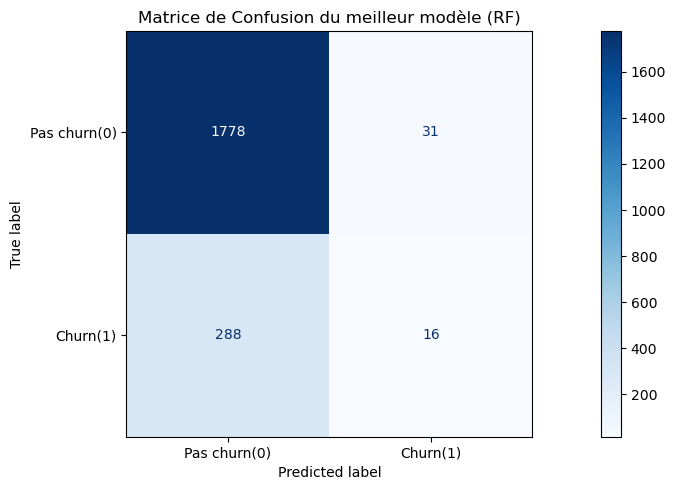

In [20]:
# CM pour Random Forest model (le meilleur)
cm = confusion_matrix(y_test, y_pred_rf, labels=[0,1])
fig, axes = plt.subplots(1,1, figsize=(14,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Pas churn(0)', 'Churn(1)'])
disp.plot(ax=axes, cmap='Blues')
plt.title("Matrice de Confusion du meilleur modèle (RF)")
plt.tight_layout()
plt.savefig(OUT_MATR_CONF_PNG, dpi=150)

<a id="3.2-feat-imp"></a>
### 3.2 Extraire et visualiser les 10 features les plus importantes
<div style="text-align: right;">
<a href="#3.2-feat-imp-toc">⬆ Retour en haut</a>
</div>

Les 10 features les plus importantes pour le modèle 'RandomForestClassifier' :

=> Fichier csv des features importances enregistrées : /home/jovyan/output/sklearn/features_importance.csv


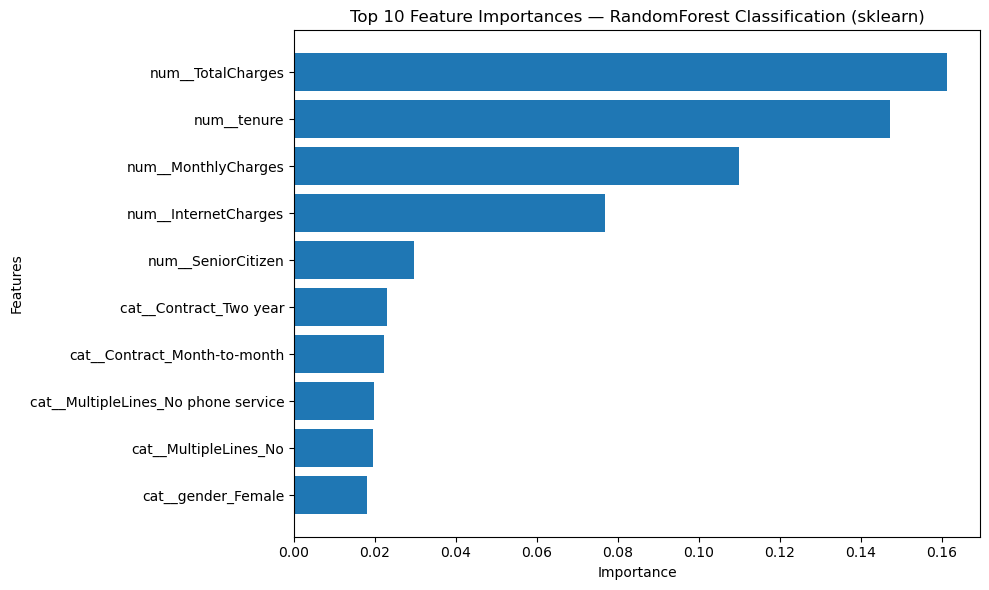

In [21]:
def get_feature_names_from_column_transformer(ct: ColumnTransformer) -> list[str]:
    """Return feature names list from column transformer for both regression & classifier models"""
    # Compatible sklearn >= 1.0
    try:
        return list(ct.get_feature_names_out())
    except Exception:
        # Fallback (rare)
        names = []
        for name, trans, cols in ct.transformers_:
            if name == "remainder":
                continue
            if hasattr(trans, "get_feature_names_out"):
                try:
                    part = list(trans.get_feature_names_out(cols))
                except Exception:
                    part = [f"{name}__{c}" for c in cols]
            else:
                part = [f"{name}__{c}" for c in cols]
            names.extend(part)
        return names

def top_feature_importances(pipe: Pipeline, k: int = 10) -> pd.DataFrame:
    """Return data frame of top feature importances for both regression & classifier models"""
    preprocessor = pipe.named_steps["preprocessor"]
    model = pipe.named_steps["model"]

    if not hasattr(model, "feature_importances_"):
        raise ValueError("Le modèle ne fournit pas feature_importances_")

    feat_names = get_feature_names_from_column_transformer(preprocessor)
    imps = model.feature_importances_
    df_imp = pd.DataFrame({"feature": feat_names, "importance": imps})
    df_imp = df_imp.sort_values("importance", ascending=False).head(k).reset_index(drop=True)
    return df_imp

top_rf = top_feature_importances(pipeline_rf, k=10)
print(f"Les 10 features les plus importantes pour le modèle 'RandomForestClassifier' :")
      
# --- Visualisation
top_sorted = top_rf.sort_values("importance", ascending=True) # Trier (sécurité si pas déjà trié)

plt.figure(figsize=(10,6))
plt.barh(
    top_sorted["feature"],
    top_sorted["importance"]
)
plt.title("Top 10 Feature Importances — RandomForest Classification (sklearn)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.savefig(OUT_VIS_FEAT_IMP_PNG, dpi=150)

# --- Enregistrement sur csv 
top_sorted = top_sorted.sort_values("importance", ascending=False).reset_index(drop=True)
top_sorted.to_csv(OUT_FEAT_IMP_CSV, index=False)
print(f"\n=> Fichier csv des features importances enregistrées : {OUT_FEAT_IMP_CSV}")

<a id="3.3-Cross-validation"></a>
### 3.3 Cross-validation (5-fold)
<div style="text-align: right;">
<a href="#3.3-Cross-validation-toc">⬆ Retour en haut</a>
</div>

In [22]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # meilleur car les classes de la target sont fortement déséquilibrées

results = cross_validate(
    pipeline_rf, X, y, cv=skf,
    scoring=["accuracy", "f1_macro", "precision_macro", "recall_macro"],
    return_train_score=True
)

print(f"Test recall : {results['test_recall_macro'].mean():.4f} (+/- {results['test_recall_macro'].std():.4f})")
print(f"Train recall : {results['train_recall_macro'].mean():.4f} (+/- {results['train_recall_macro'].std():.4f})")
print(f"Test F1 : {results['test_f1_macro'].mean():.4f} (+/- {results['test_f1_macro'].std():.4f})")
print(f"Train F1 : {results['train_f1_macro'].mean():.4f} (+/- {results['train_f1_macro'].std():.4f})")
print(f"Test précision : {results['test_precision_macro'].mean():.4f} (+/- {results['test_precision_macro'].std():.4f})")
print(f"Test accuracy : {results['test_accuracy'].mean():.4f} (+/- {results['test_accuracy'].std():.4f})")
print(f"Time : {results['fit_time'].mean():.4f}")


Test recall : 0.5120 (+/- 0.0072)
Train recall : 0.9955 (+/- 0.0015)
Test F1 : 0.4930 (+/- 0.0134)
Train F1 : 0.9971 (+/- 0.0009)
Test précision : 0.5785 (+/- 0.0364)
Test accuracy : 0.8494 (+/- 0.0014)
Time : 0.1546


<a id="3.4-GridSearchCV"></a>
### 3.4 GridSearchCV pour optimisation hyperparametres
<div style="text-align: right;">
<a href="#3.4-GridSearchCV-toc">⬆ Retour en haut</a>
</div>

In [23]:
# --- Grille d'hyperparamètres
param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 8, 16],
    "model__min_samples_split": [2, 10],
    "model__min_samples_leaf": [1, 5],
    "model__max_features": ["sqrt", "log2"],
    "model__class_weight": [None, "balanced", "balanced_subsample"]
}

# --- CV stratifiée
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- GridSearchCV ---
grid = GridSearchCV(
    pipeline_rf,
    param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1,
    return_train_score=True
)

t0 = time.time()
grid.fit(X_train, y_train)
t_grid_fit = time.time() - t0

print("-Meilleurs paramètres :", grid.best_params_)
print("-Meilleur score CV (recall) :", grid.best_score_)
final_model = grid.best_estimator_ # meilleur reglage
print("-Meilleur modèle :", final_model)

t0 = time.time()
y_pred_tuned = final_model.predict(X_test)
t_pred_tuned = time.time() - t0

print("-Rapport de test avec le modèle avec les meilleurs hyperparams : ")
print(classification_report(y_test, y_pred_tuned, digits=3))

print(f"-temps d'entrainement (meilleur modele): {t_grid_fit:.1f} sec")
print(f"-temps de prédiction (meilleur modele): {t_pred_tuned:.1f} sec")

-Meilleurs paramètres : {'model__class_weight': 'balanced_subsample', 'model__max_depth': 8, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 200}
-Meilleur score CV (recall) : 0.4131755069423634
-Meilleur modèle : Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'InternetCharges',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                               

---

### 4. RECOMMANDATIONS METIER
<div style="text-align: right;">
<a href="#4.-RECOMMANDATIONS-METIER-toc">⬆ Retour en haut</a>
</div>

<a id="41-prob-churn"></a>
### 4.1 Identifier les 20 clients avec probabilité churn > 80%
<div style="text-align: right;">
<a href="#41-prob-churn-toc">⬆ Retour en haut</a>
</div>

In [24]:
# --- Creation de df_scored avec la colonne churn_proba
proba = final_model.predict_proba(X)[:, 1] # => À partir des caractéristiques des clients (X), calcule leur probabilité de churn

df_scored = df_tr.copy()
df_scored["churn_proba"] = proba

# --- Enregistrement de predictions_test.csv
df_scored.to_csv(OUT_PRED_TEST_CSV)
print(f"=> Fichier de prediction enregistré : {OUT_PRED_TEST_CSV}")

# --- Identification des 20 clients avec probabilité churn > 80%
print("=> Identification des 20 clients avec probabilité churn > 80% :")
high_risk = df_scored[df_scored["churn_proba"] >= 0.80].sort_values("churn_proba", ascending=False)
top_20 = high_risk.head(20)
top_20.head(20)

# --- Enregistrement de des clients avec probabilité churn > 80%

top_20.to_csv(OUT_HIGH_RISK_CSV)
print(f"=> Fichier des clients avec probabilité churn > 80% enregistré : {OUT_HIGH_RISK_CSV}")

=> Fichier de prediction enregistré : /home/jovyan/output/sklearn/predictions_test.csv
=> Identification des 20 clients avec probabilité churn > 80% :
=> Fichier des clients avec probabilité churn > 80% enregistré : /home/jovyan/output/sklearn/top_risk_churn_client.csv


<a id="42-analyse-profils"></a>
### 4.2 Analyser leurs profils (Contract, InternetService, tenure, MonthlyCharges)
<div style="text-align: right;">
<a href="#42-analyse-profils-toc">⬆ Retour en haut</a>
</div>


In [25]:
profile_cols = [c for c in ["Contract", "InternetService", "tenure", "MonthlyCharges"] if c in top_20.columns]

display(top_20[profile_cols].describe(include="all"))

,Contract,InternetService,tenure,MonthlyCharges
count,9,9,9.000000,9.000000
unique,2,1,NaN,NaN
top,Month-to-month,Fiber optic,NaN,NaN
freq,6,9,NaN,NaN
mean,NaN,NaN,1.888889,162.242222
std,NaN,NaN,1.364225,27.376369
min,NaN,NaN,0.000000,128.110000
25%,NaN,NaN,1.000000,138.350000
50%,NaN,NaN,2.000000,165.890000
75%,NaN,NaN,3.000000,181.510000


-> Surreprésentation des contrats **Month-to-month**  
-> Surreprésentation de la fibre optique (**Fiber optic**) comme service internet  
-> **Tenure** majoritairement faible (nouveaux clients)  
-> **MonthlyCharges** élevés (prix perçu trop cher)  

<a id="4.3-actions"></a>
### 4.3 Proposer 3 actions de retention
<div style="text-align: right;">
<a href="#4.3-actions-toc">⬆ Retour en haut</a>
</div>

- Migration vers un contrat 1 ou 2 ans (en les encouragent avec une remise et/ou 1 ou quelques mois offerts)
- Pour les clients qui ont la fibre optique : après recueil de leurs avis (via des appels proactifs), proposer des services supplémentaires gratuitement
- Pour les nouveaux clients (tenur faible) : appel proactif + résolution des éventuels problemes de facturation, débit ...etc

<a id="4.4-ROI"></a>
### 4.4 Estimer ROI (cout action vs economie)
<div style="text-align: right;">
<a href="#4.4-ROI-toc">⬆ Retour en haut</a>
</div>

D'après les données : 
- Client perdu = 500€ de perte mensuelle (perte_par_mois)
- Nombre de clients ciblés (qui risquent de churn : poba. > 80%) : (N = len(high_risk))

Suppositions :
- On va invertir 100 € en actions pour essayer de convertir chaque client (actions comme mails, SMS, appels ...) (cout)
- On va gagner : 10% des clients (clients_gagnes)  -  pendant 3 mois de plus (mois_sauves)


In [26]:
N = len(high_risk)
perte_par_mois = 500

cout = 100
clients_gagnes = 0.1
mois_sauves = 3

sauves_prevus = N * clients_gagnes * perte_par_mois * mois_sauves
cout_prevu = cout * N

roi = ((sauves_prevus - cout_prevu) / cout_prevu) * 100 

print("N ciblés:", N)
print("Gain attendu (€):", sauves_prevus)
print("Coût attendu (€):", cout_prevu)
print(f"ROI: {roi:0.2f} %")

N ciblés: 9
Gain attendu (€): 1350.0
Coût attendu (€): 900
ROI: 50.00 %


=> Très bon retour sur investissement.